In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pathlib import Path
from scipy import signal
from scipy.fft import ifft
from scipy.signal import savgol_filter

In [2]:
# Convert rfft PSD to autocorrelation
def psd_to_acf(psd):
   
    # reconstruct full PSD for real signal
    pos  = psd
    neg  = psd[1:-1][::-1]
    full = np.concatenate([pos, neg])
    acov = np.real(ifft(full))
    acf  = acov / acov[0]
    return acf


# Main analysis
def analyze_acf(psd_before, psd_after):
    """Compute and plot ACF for before and after PSDs.
    
    Args:
        before_psd: 1D array of original PSD
        psd_after: 1D array of denoised PSD
    """
    acf_before = psd_to_acf(psd_before)
    acf_after  = psd_to_acf(psd_after)

    # Plot ACF
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.stem(acf_before[:30]); plt.title("ACF from PSD (before)")
    plt.subplot(1,2,2)
    plt.stem(acf_after[:30]); plt.title("ACF from PSD (after)")
    plt.show()



def psd_correlation_comparison(psd_before, psd_after, segment_length=5000, sg_window=1001, poly=3):
    """Compute and plot segment-to-segment correlation matrices for before and after PSDs.
    
    Args:
        psd_before: 1D array of original PSD
        psd_after: 1D array of denoised PSD
        segment_length: length of PSD segments
        sg_window: window length for Savitzky-Golay filter (odd number)
        poly: polynomial order for SG filter
    """
    def compute_corr(psd):
        window = sg_window
        if window % 2 == 0:
            window += 1
        psd_smooth    = savgol_filter(psd, window_length=window, polyorder=poly)
        psd_detrended = psd / psd_smooth
        plt.plot(psd_detrended,label="after sg filter")
        plt.legend()
        plt.show()
        psd_diff = psd - psd_smooth
        plt.plot(psd_diff/psd,label=f"diff/original | mean = {(psd_diff/psd).mean():.5f}")
        plt.legend()
        plt.show()
        # reshape into segments
        n_segments = len(psd_detrended) // segment_length  # in total 40 segments
        psd_2d     = psd_detrended[:n_segments*segment_length].reshape(n_segments, segment_length)
        
        # correlation matrix
        corr_matrix = np.corrcoef(psd_2d)
        return corr_matrix
    
    corr_before = compute_corr(psd_before)
    corr_after  = compute_corr(psd_after)
    
    # plot side by side
    fig = plt.figure(figsize=(12,6))
    gs = gridspec.GridSpec(2, 2, height_ratios=[0.05, 1], width_ratios=[1, 1], 
                        hspace=0.3, wspace=0.2)

    # Subplots for the main plots
    ax0 = fig.add_subplot(gs[1, 0])  # Bottom left
    ax1 = fig.add_subplot(gs[1, 1])  # Bottom right

    # Create the plots
    im0 = ax0.imshow(corr_before, cmap='coolwarm', vmin=-0.2, vmax=0.2)
    ax0.set_title("Before Denoising")
    ax0.set_xlabel("Segment index"); ax0.set_ylabel("Segment index")

    im1 = ax1.imshow(corr_after, cmap='coolwarm', vmin=-0.2, vmax=0.2)
    ax1.set_title("After Denoising")
    ax1.set_xlabel("Segment index"); ax1.set_ylabel("Segment index")

    # Colorbar on top spanning both columns
    cbar_ax = fig.add_subplot(gs[0, :])  # Top row, all columns
    cbar = fig.colorbar(im1, cax=cbar_ax, orientation='horizontal')
    cbar.set_label('Correlation')

    plt.show()


def cross_correlate_and_plot(noise_data, denoised_data):
    """Cross-correlate two pairs of arrays and plot both results.
    
    Args:
        noise_data: list of noise PSD arrays
        denoised_data: list of denoised PSD arrays
    """
    
    # Get data arrays
    noise1, noise2 = noise_data[0], noise_data[1]
    denoised1, denoised2 = denoised_data[0], denoised_data[1]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    
    # Noise cross-correlation
    cross_corr_noise = signal.correlate(noise1, noise2, mode='full')
    lags_noise       = signal.correlation_lags(len(noise1), len(noise2), mode='full')
    cross_corr_noise = cross_corr_noise / (len(noise1) * np.std(noise1) * np.std(noise2))

    # Additional normalization to same scale
    cross_corr_noise = cross_corr_noise / np.max(np.abs(cross_corr_noise))
    
    ax1.plot(lags_noise, cross_corr_noise)
    ax1.axhline(y=0, color='r', linestyle='--')
    ax1.set_xlabel('Lag')
    ax1.set_ylabel('Cross-correlation')
    ax1.set_title('Before Denoising Cross-correlation')
    ax1.grid(True)
    
    # Denoised cross-correlation
    cross_corr_denoised = signal.correlate(denoised1, denoised2, mode='full')
    lags_denoised = signal.correlation_lags(len(denoised1), len(denoised2), mode='full')
    cross_corr_denoised = cross_corr_denoised / (len(denoised1) * np.std(denoised1) * np.std(denoised2))
    # Additional normalization to same scale
    cross_corr_denoised = cross_corr_denoised / np.max(np.abs(cross_corr_denoised))
    
    ax2.plot(lags_denoised, cross_corr_denoised)
    ax2.axhline(y=0, color='r', linestyle='--')
    ax2.set_xlabel('Lag')
    ax2.set_ylabel('Cross-correlation')
    ax2.set_title('After Denoising Cross-correlation')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Find max correlations
    max_idx_noise    = np.argmax(np.abs(cross_corr_noise))
    max_idx_denoised = np.argmax(np.abs(cross_corr_denoised))
    
    print(f"Noise max correlation: {cross_corr_noise[max_idx_noise]:.4f} at lag {lags_noise[max_idx_noise]}")
    print(f"Denoised max correlation: {cross_corr_denoised[max_idx_denoised]:.4f} at lag {lags_denoised[max_idx_denoised]}")


directory = Path('Misc/')
file_list = sorted(directory.glob(f'uninjected*dae.h5'))
# file_list = sorted(directory.glob(f'uninjected*unet.h5'))

denoised = []
noise    = []

# Grabs two uninjected noise files for testing
for i, filename in enumerate(file_list):
    f = h5py.File(filename, 'r')
    print(f'File {i + 1}: {filename.stem}')

    # Data = log1p(x), so must do e ** (Data) - 1
    noise_scaled    = np.exp(f['input'][:]) - 1 
    denoised_scaled = np.exp(f['denoised'][:]) - 1

    # Index 0 will be file 1 and index 1 will be file 2
    noise.append(noise_scaled)
    denoised.append(denoised_scaled)

File 1: uninjected_7545564_denoised_dae
File 2: uninjected_7545571_denoised_dae


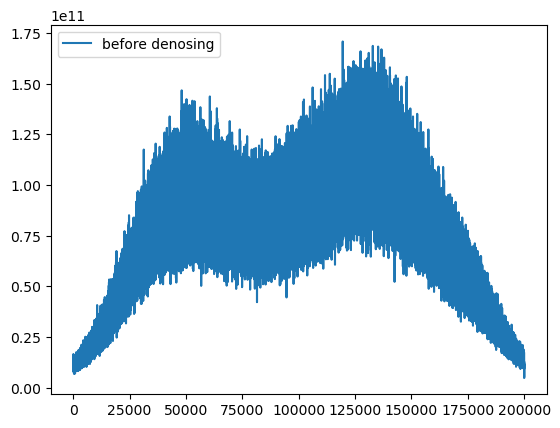

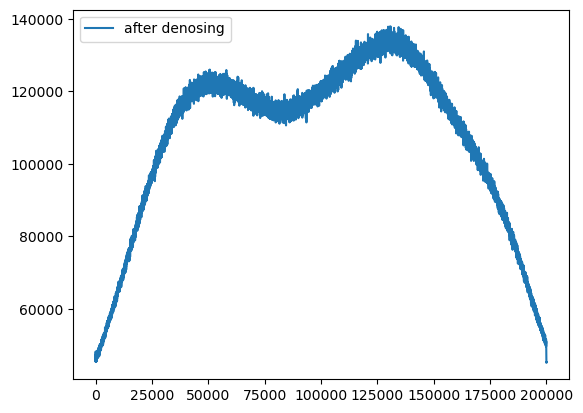

In [3]:
plt.plot(noise[0],label='before denosing')
plt.legend()
plt.show()

plt.plot(denoised[0],label='after denosing')
plt.legend()
plt.show()

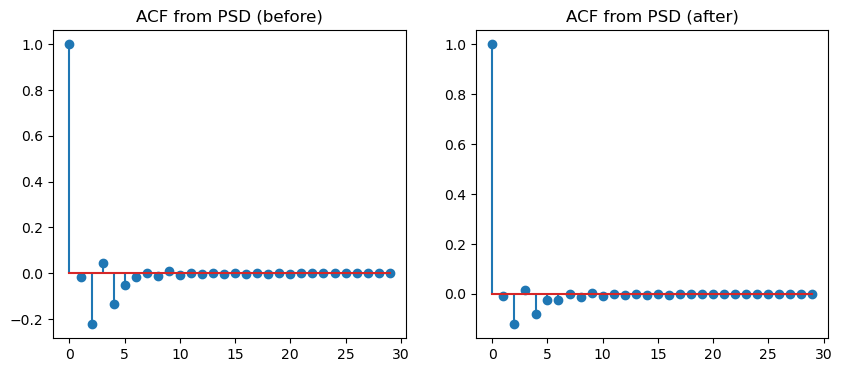

In [4]:

# Plots ACF before and after denoising 
# File 1 = index 0
# File 2 = index 1
index = 0
analyze_acf(noise[index], denoised[index])

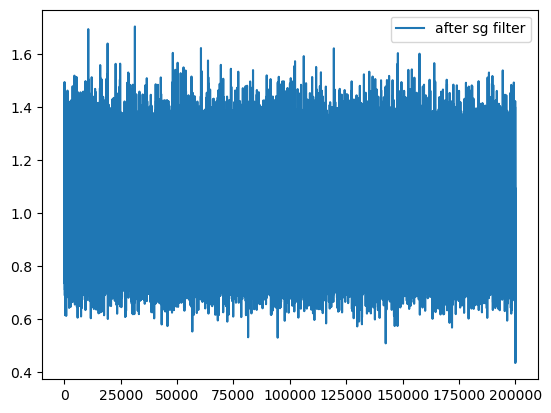

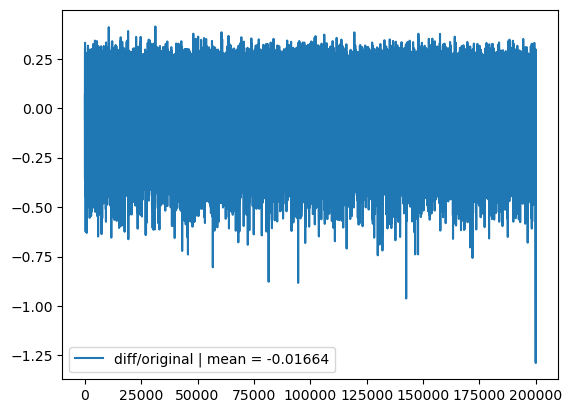

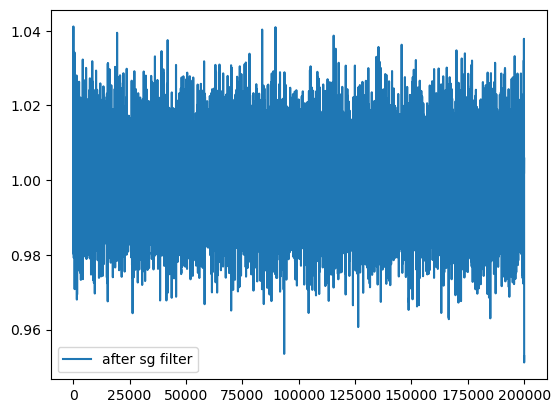

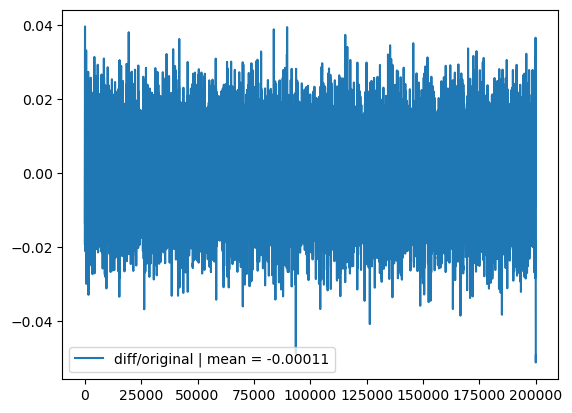

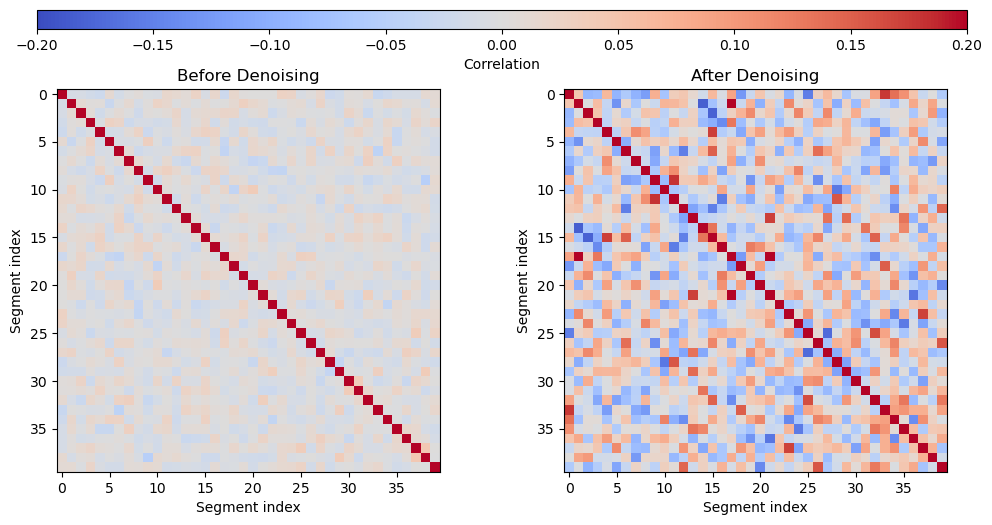

In [5]:
# Plots numpy corrcoef before and after denoising
index = 0
psd_correlation_comparison(noise[index], denoised[index])

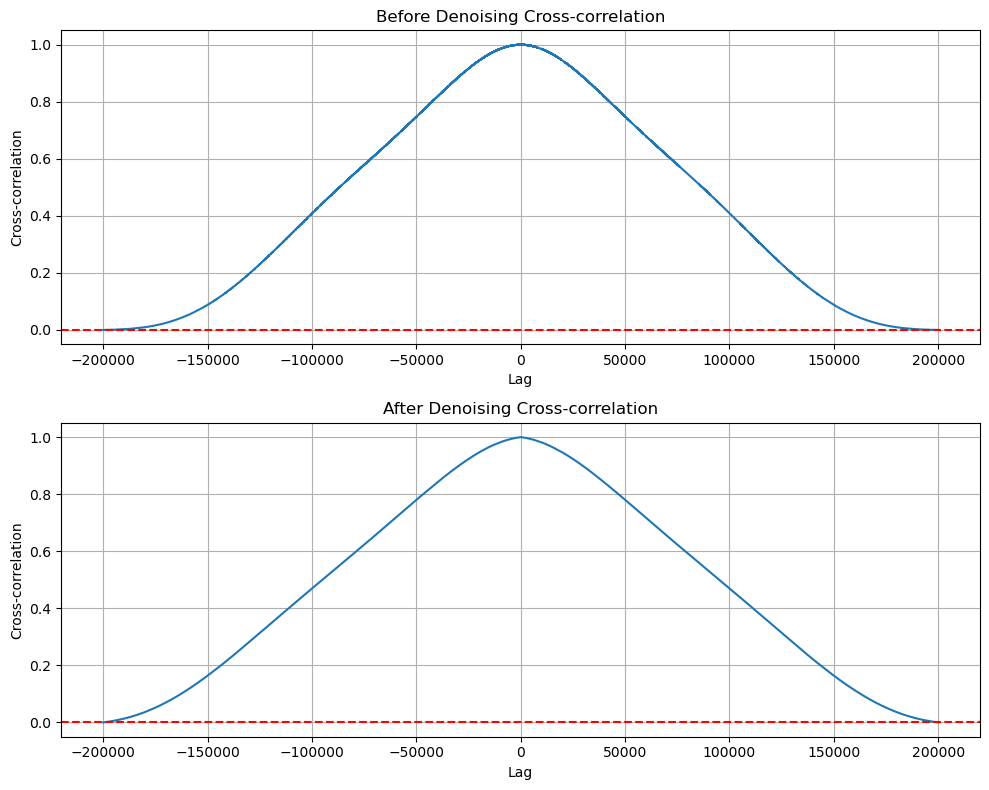

Noise max correlation: 1.0000 at lag -2
Denoised max correlation: 1.0000 at lag 0


In [6]:
# Plots cross correlation of both noisy files
# https://www.perplexity.ai/search/i-have-two-files-each-with-a-1-ZzASH6x1Qkm3D0rNOSk9RA
cross_correlate_and_plot(noise, denoised)